## Random Search for Hyperparameters


https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
)

In [2]:
# if you want more information about the dataset for this demo:

# scikit-learn dataset
# https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset

# dataset information: UCI Machine Learning Repository
# https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
    
# in short, classification problem, trying to predict whether the tumor
# is malignant or benign

# load dataset
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

0    0.627417
1    0.372583
dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

In [5]:
stats.randint.rvs(1, 5)

4

In [6]:
stats.uniform.rvs(0, 1)

0.49247918130652757

## Random Search

Let's use Grid Search to find the best hyperparameters for a Gradient Boosting Classifier.

In [7]:
# set up the model
gbm = GradientBoostingClassifier(random_state=0)

# determine the hyperparameter space
param_grid = dict(
    n_estimators=stats.randint(10, 120),
    min_samples_split=stats.uniform(0, 1),
    max_depth=stats.randint(1, 5),
    loss=('deviance', 'exponential'),
    )

In [9]:
# set up the search
search = RandomizedSearchCV(gbm,
                            param_grid,
                            scoring='roc_auc',
                            cv=5,
                            n_iter = 60,
                            random_state=10,
                            n_jobs=-1,
                            refit=True)

# find best hyperparameters
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'loss': ('deviance', 'exponential'),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3d5bd842e0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3d5bd8f0d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3dd973d7f0>},
                   random_state=10, scoring='roc_auc')

In [10]:
# the best hyperparameters are stored in an attribute

search.best_params_

{'loss': 'exponential',
 'max_depth': 3,
 'min_samples_split': 0.5345579488018151,
 'n_estimators': 99}

In [11]:
# we also find the data for all models evaluated

results = pd.DataFrame(search.cv_results_)

print(results.shape)

results.head()

(60, 17)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.186589,0.010559,0.004525,0.000906,exponential,2,0.020752,74,"{'loss': 'exponential', 'max_depth': 2, 'min_s...",1.000000,0.983333,0.989333,0.999310,0.991837,0.992763,0.006273,3
1,0.197806,0.015990,0.003957,0.000831,exponential,4,0.831911,103,"{'loss': 'exponential', 'max_depth': 4, 'min_s...",1.000000,0.973000,0.988000,0.998621,0.987075,0.989339,0.009733,24
2,0.053221,0.003519,0.004649,0.000505,deviance,2,0.198063,18,"{'loss': 'deviance', 'max_depth': 2, 'min_samp...",0.994667,0.965667,0.974333,0.987241,0.978912,0.980164,0.010061,51
3,0.076980,0.005405,0.003746,0.000714,exponential,1,0.263603,46,"{'loss': 'exponential', 'max_depth': 1, 'min_s...",0.998333,0.957667,0.983000,0.991724,0.979592,0.982063,0.013858,50
4,0.031403,0.001548,0.004251,0.001072,exponential,1,0.816602,21,"{'loss': 'exponential', 'max_depth': 1, 'min_s...",0.994000,0.948333,0.967333,0.986207,0.969048,0.972984,0.015947,55


In [12]:
# we can order the different models based on their performance
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results[[
    'param_max_depth', 'param_min_samples_split', 'param_n_estimators',
    'mean_test_score', 'std_test_score',
]].head()

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score
0,3,0.534558,99,0.993171,0.006967
1,2,0.043097,115,0.992885,0.005906
2,2,0.020752,74,0.992763,0.006273
3,4,0.565507,92,0.992689,0.006204
4,2,0.30546,92,0.992567,0.007091


In [13]:
results[[
    'param_max_depth', 'param_min_samples_split', 'param_n_estimators',
    'mean_test_score', 'std_test_score',
]].tail()

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score
55,4,0.781949,18,0.972361,0.015814
56,2,0.821106,21,0.971264,0.011818
57,1,0.653623,14,0.969349,0.011463
58,1,0.10462,10,0.964248,0.016026
59,2,0.820704,10,0.964244,0.015191


Text(0.5, 0, 'Hyperparameter combinations')

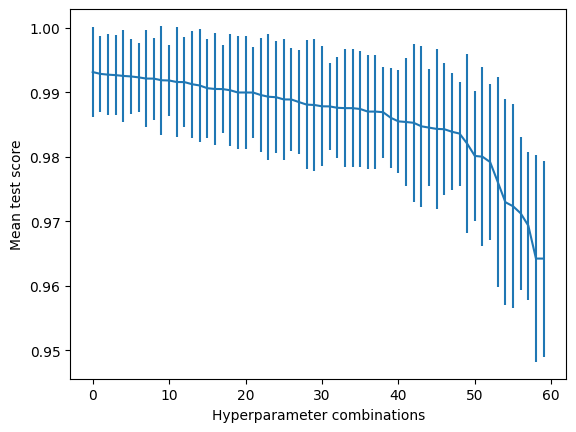

In [14]:
# plot model performance and error

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [15]:
X_train_preds = search.predict_proba(X_train)[:,1]
X_test_preds = search.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

Train roc_auc:  1.0
Test roc_auc:  0.9988242210464433


In [16]:
# let's make a function to evaluate the model performance based on
# single hyperparameters

def summarize_by_param(hparam):
    
    tmp = pd.concat([
        results.groupby(hparam)['mean_test_score'].mean(),
        results.groupby(hparam)['mean_test_score'].std(),
    ], axis=1)

    tmp.columns = ['mean_test_score', 'std_test_score']
    
    return tmp

In [17]:
# performance change for n_estimators

tmp = summarize_by_param('param_n_estimators')

tmp.head()

,mean_test_score,std_test_score
param_n_estimators,,
10,0.964246,0.000003
14,0.969349,NaN
16,0.979216,NaN
17,0.984554,NaN
18,0.976262,0.005518


Text(0, 0.5, 'roc-auc')

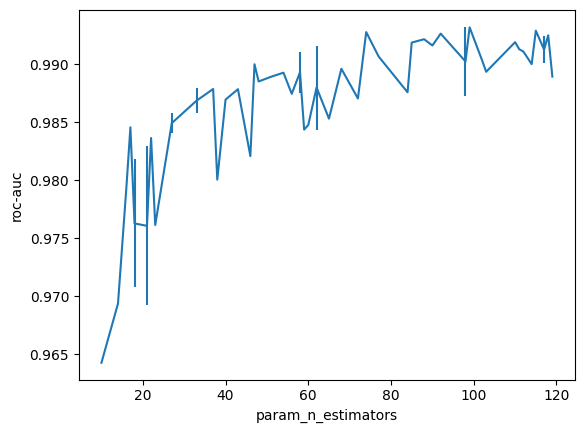

In [18]:
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.ylabel('roc-auc')

The optimal hyperparameter seems to be somewhere between 60 and 100.

Text(0, 0.5, 'roc-auc')

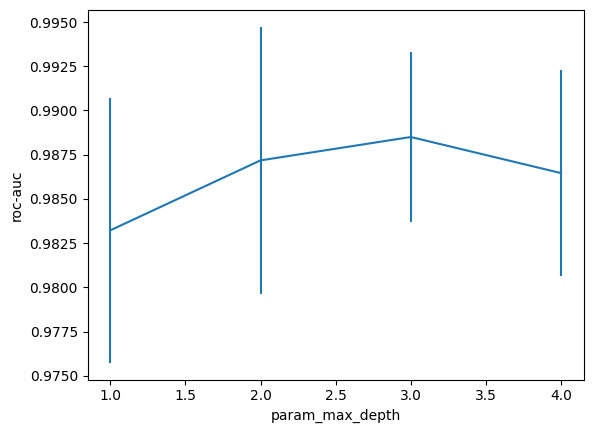

In [19]:
tmp = summarize_by_param('param_max_depth')
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.ylabel('roc-auc')

The optimal hyperparameter seems to be between 2 and 3.

/home/kuhn/Github_local/hyperparameter-optimization/.venv/hyperparameter-optimization/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


array([<AxesSubplot:xlabel='param_min_samples_split'>], dtype=object)

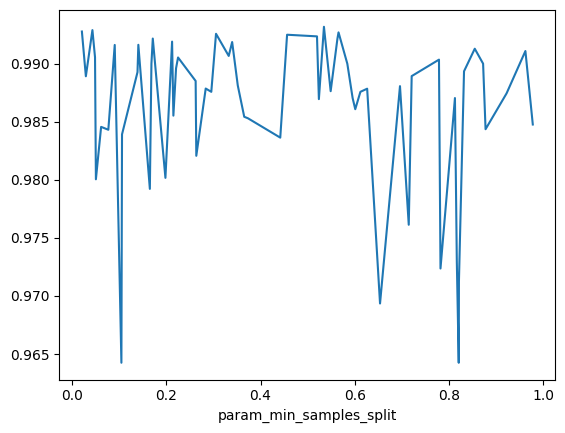

In [20]:
tmp = summarize_by_param('param_min_samples_split')
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)

This parameter does not seem to improve performance much.

(0.97, 1.0)

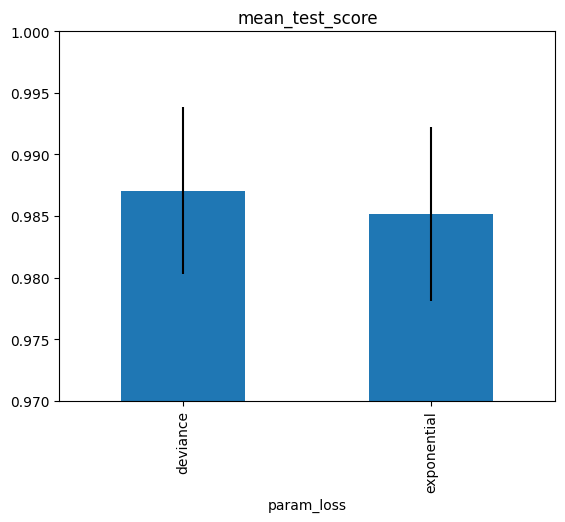

In [21]:
tmp = summarize_by_param('param_loss')
tmp['mean_test_score'].plot.bar(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.ylim(0.97,1)